In [143]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from mpl_toolkits import mplot3d

def read_data(filename):
	with open(filename) as f:
		s = f.read()

	return np.fromstring(s, sep=' ')

def read_points(filename):
	pts = read_data(filename)
	ps = []
	for i in range(int(len(pts) / 4)):
		ps.append([pts[j] for j in range(i*4, 4*i+4)])

	ps1 = np.array([[p[0], p[1]] for p in ps])
	ps2 = np.array([[p[2], p[3]] for p in ps])

	return ps1, ps2

$ d = x_1 - x_2 = f(\frac{p_x}{p_z} + \frac{T - p_x}{p_z}) = f\frac{T}{p_z} $

There is an inverse relationship between distance to camera and disparity. The closer the object, teh larger the disparity.

Text(0.5, 0, 'p_z [m]')

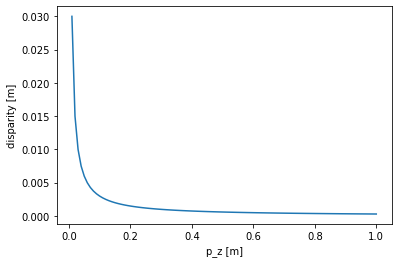

In [2]:
def disparity(pz, T, f):
	return f*T/pz

f = 0.25e-2
T = 12e-2 # m

pz = np.linspace(0.01, 1, 100)
d = disparity(pz, T, f)

plt.plot(pz, d)
plt.ylabel("disparity [m]")
plt.xlabel("p_z [m]")

In [77]:
f = 2.5e-3
T = 12e-2
pixel_width = 7.4e-6
w_p = 648
h_p = 488 

In [94]:
def pixel_to_pz(f, T, pixel_width, w_p, h_p, xp1, xp2):
	x1 = xp1*pixel_width - w_p*pixel_width/2
	x2 = xp2*pixel_width - w_p*pixel_width/2
	d = x1 - x2
	return f*T / d
	

In [97]:
pixel_to_pz(f,T,pixel_width, w_p, h_p, 550, 300)

0.16216216216216217

## BONUS

In [159]:
def ncc(x, y):
	mx = x.mean()
	my = y.mean()
	n = x.size
	return np.sum((x - mx)*(y - my)) / (np.sqrt(np.sum((x - mx)**2) / n) * np.sqrt(np.sum((y - my)**2) / n) * n)

def disparity(I1, I2, size=10, limit=100):
	D = np.zeros(I1.shape)
	for i in tqdm(range(size, I1.shape[0] - size)):
		for j in range(size, I1.shape[1]- size):
			x = I1[i-size:i+size+1, j-size:j+size+1]
			y = I2[i-size:i+size+1, j-size:j+size+1]

			d = j
			ncc_max = ncc(x, y)
			for k in range(min(j+limit, I1.shape[1] - limit - 1), max(j-limit, limit), -1):
				y = I2[i-size:i+size+1, k-size:k+size+1]
				nc = ncc(x, y)
				if (nc > ncc_max):
					d = k
					ncc_max = nc
			
			D[i, j] = j - d
	return D

In [168]:
I1 = cv2.imread("./data/disparity/office2_left.png")
I1 = cv2.cvtColor(I1, cv2.COLOR_BGR2GRAY)
I1 = cv2.resize(I1, (int(I1.shape[1]/2), int(I1.shape[0]/2)))
I2 = cv2.imread("./data/disparity/office2_right.png")
I2 = cv2.cvtColor(I2, cv2.COLOR_BGR2GRAY)
I2 = cv2.resize(I2, (int(I2.shape[1]/2), int(I2.shape[0]/2)))

d1 = disparity(I1, I2, 12, 12)
d2 = disparity(I2, I1, 12, 12)

100%|██████████| 184/184 [01:38<00:00,  1.87it/s]


In [193]:
d = np.zeros_like(d1)
for i in range(d1.shape[0]):
		for j in range(d1.shape[1]):
			dd = d1[i,j]
			d[i,j] = (dd - d2[i, int(j - dd)])/2
d = 255*(d/12 + 1)/2
d = d.astype("uint8")
d = cv2.medianBlur(d, 5)

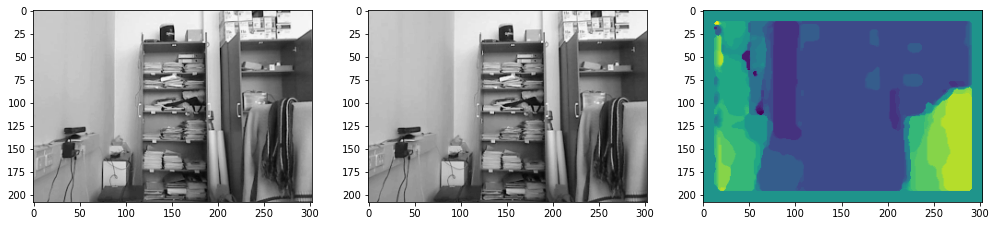

In [194]:
plt.rcParams["figure.figsize"] = (17,5)

plt.subplot(131)
plt.imshow(I1, cmap="gray")

plt.subplot(132)
plt.imshow(I2, cmap="gray")

plt.subplot(133)
plt.imshow(d)

---
# Exercise 2: Fundamental matrix, epipoles, epipolar lines

In [690]:
F = np.array([[0,0,0.002], [0,0,-0.012], [-0.001, 0.011, -0.085]])
x = np.array([[300, 120, 1]]).T
l2 = F @ x
xp = np.array([[300, 170, 1]]).T
l2p = F @ xp

print(l2.T)
print(l2p.T)

[[ 0.002 -0.012  0.935]]
[[ 0.002 -0.012  1.485]]


0.002 * x - 0.012 * y + 0.935 = 0

0.002 * x - 0.012 * y - 1.485 = 0

They intersect at infinity

In [305]:
def fundamental_matrix(p1s, p2s):
	n = p1s.shape[0]
	A = np.zeros((n, 9))
	for i in range(n):
		p2 = p2s[i]
		A[i] = np.hstack((p1s[i, 0]*p2, p1s[i, 1]*p2, p2))
	
	[U, S, V] = np.linalg.svd(A)
	V = V.T
	Ft = V[:, np.argmin(S)].reshape((3,3))

	[U, S, V] = np.linalg.svd(Ft)
	S[2] = 0
	F = U @ np.diag(S) @ V

	'''[U, S, V] = np.linalg.svd(F)
	V = V.T
	e1 = V[:, 2] / V[2,2]6
	e2 = U[:, 2] / U[2,2]'''

	return F.T

import a5_utils
def fundamental_matrix_n(p1s, p2s):
	p1sn, T1 = a5_utils.normalize_points(p1s)
	p2sn, T2 = a5_utils.normalize_points(p2s)
	Fh = fundamental_matrix(p1sn, p2sn)
	F = T2.T @ Fh @ T1
	return F

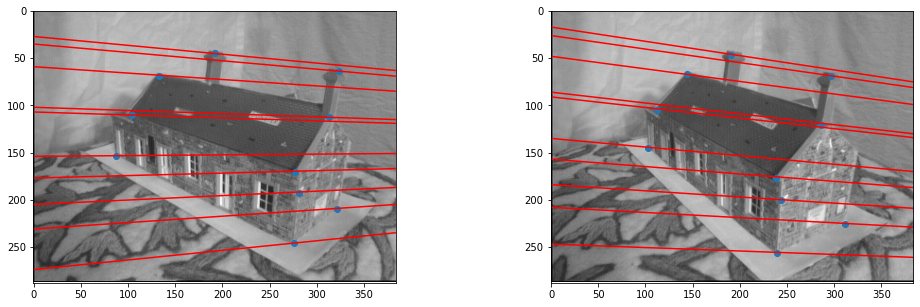

In [333]:
I1 = cv2.imread("./data/epipolar/house1.jpg")
I1 = cv2.cvtColor(I1, cv2.COLOR_BGR2GRAY)
I2 = cv2.imread("./data/epipolar/house2.jpg")
I2 = cv2.cvtColor(I2, cv2.COLOR_BGR2GRAY)

p1s, p2s = read_points("./data/epipolar/house_points.txt")
F = fundamental_matrix_n(p1s, p2s)
p1s = np.hstack((p1s, np.ones((p1s.shape[0], 1))))
p2s = np.hstack((p2s, np.ones((p2s.shape[0], 1))))
l1s = (F.T @ p2s.T).T
l2s = (F @ p1s.T).T

plt.subplot(121)
plt.imshow(I1, cmap="gray")
plt.scatter(p1s[:, 0], p1s[:, 1])
for i in range(l1s.shape[0]):
	a5_utils.draw_epiline(l1s[i], I1.shape[0], I1.shape[1])

plt.subplot(122)
plt.imshow(I2, cmap="gray")
plt.scatter(p2s[:, 0], p2s[:, 1])
for i in range(l2s.shape[0]):
	a5_utils.draw_epiline(l2s[i], I2.shape[0], I2.shape[1])

In [313]:
d = read_data("./data/epipolar/house_fundamental.txt").reshape((3,3))
print(F - d)

[[ 4.93016903e-16 -6.78812204e-18 -2.77555756e-17]
 [ 2.42720679e-16  1.70043982e-17 -3.07046055e-16]
 [-3.95300112e-16  1.21430643e-16  1.14630527e-14]]


In [363]:
def reproduction_error(p1, p2, F):
	def distance(l, p):
		return np.abs(np.sum(l*p))/np.sqrt(l[0]**2 + l[1]**2)

	l1 = (F.T @ p2).T
	l2 = (F @ p1).T
	d1 = distance(l1, p1)
	d2 = distance(l2, p2)
	return (d1 + d2)/2

In [397]:
p1 = np.array([85, 233, 1])
p2 = np.array([67, 219, 1])
print(reproduction_error(p1 ,p2, F))

0.14674365570472347


In [366]:
a = 0
for i in range(p1s.shape[0]):
	a += reproduction_error(p1s[i], p2s[i], F)
a /= p1s.shape[0]
print(a)

0.33091336980536845


---
## Ransac

In [632]:
def get_inliers(F, p1s, p2s, eps):
	ins = []
	for i in range(p1s.shape[0]):
		if reproduction_error(np.hstack((p1s[i], 1)), np.hstack((p2s[i], 1)), F) < eps:
			ins.append(i)
	return p1s[ins], p2s[ins], ins

def ransac_fundamental(p1s, p2s, eps=2, k=100):
	max_r = []
	max_r_ins = []
	max_r_n_ins = 0
	for i in range(k):
		r = np.random.randint(0, p1s.shape[0], 8)
		F = fundamental_matrix_n(p1s[r], p2s[r])
		ins1, ins2, ins = get_inliers(F, p1s, p2s, eps)
		n_ins = ins1.shape[0]
		if n_ins > max_r_n_ins:
			max_r = r
			max_r_ins = ins
			max_r_n_ins = n_ins
	
	F = fundamental_matrix_n(p1s[max_r], p2s[max_r])
	ins1, ins2, ins = get_inliers(F, p1s, p2s, eps)

	return F, max_r, max_r_ins

In [636]:
p1s, p2s = read_points("./data/epipolar/house_matches.txt")
F, r, ins = ransac_fundamental(p1s, p2s, k=500)
print(len(ins))
print("{:.3}% inliers".format(100*len(ins) /p1s.shape[0]))

104
61.9% inliers


In [637]:
p1 = p1s[ins[0]]
p2 = p2s[ins[0]]
print("error: {:.3}".format(reproduction_error(np.hstack((p1, 1)), np.hstack((p2, 1)), F)))

l2 = (F @ np.hstack((p1, 1))).T

error: 1.32


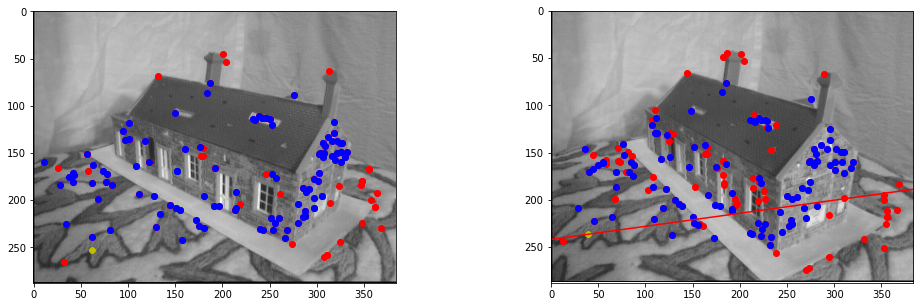

In [638]:
plt.subplot(121)
plt.imshow(I1, cmap="gray")
plt.scatter(p1s[:, 0], p1s[:, 1], color="r")
plt.scatter(p1s[ins, 0], p1s[ins, 1], color="b")
plt.scatter(p1[0], p1[1], color="y")

plt.subplot(122)
plt.imshow(I2, cmap="gray")
plt.scatter(p2s[:, 0], p2s[:, 1], color="r")
plt.scatter(p2s[ins, 0], p2s[ins, 1], color="b")
plt.scatter(p2[0], p2[1], color="y")
a5_utils.draw_epiline(l2, I2.shape[0], I2.shape[1])

In [639]:
import a4_utils

def hellinger(h1, h2):
	return np.sqrt(np.sum((np.sqrt(h1) - np.sqrt(h2))**2)/2)
def gauss(x, sigma=1):
	g = np.exp(-x**2 / (2*sigma**2)) / (sigma*np.sqrt(2*np.pi))
	return g
def gaussdx_point(w, sigma=1):
	g = -w * np.exp(-w**2 / (2*sigma**2)) / (sigma**3*np.sqrt(2*np.pi))
	return g
def gaussdx2_point(w, sigma=1):
	g = (w**2 - sigma**2) * np.exp(-w**2 / (2*sigma**2)) / (sigma**5*np.sqrt(2*np.pi))
	return g

def gaussian_kernel(sigma):
	tris = np.ceil(3*sigma)
	x = np.arange(-tris, tris+1)
	g = gauss(x, sigma)
	return (g / np.sum(g)).reshape(1, int(2*tris+1))

def gaussdx(sigma):
	tris = np.ceil(3*sigma)
	x = np.arange(-tris, tris+1)
	g = gaussdx_point(x, sigma)
	return (g).reshape(1, int(2*tris+1))

def gaussdx2(sigma):
	tris = np.ceil(3*sigma)
	x = np.arange(-tris, tris+1)
	g = gaussdx2_point(x, sigma)
	return (g).reshape(1, int(2*tris+1))


def gaussian_filter(I, sigma):
	ker = gaussian_kernel(sigma)
	I = cv2.filter2D(I, -1, ker)
	I = cv2.filter2D(I.T, -1, ker)
	return I.T


def partial_d(img, dir="x", sigma=1):
	G = gaussian_kernel(sigma)
	D = gaussdx(sigma)
	if dir == "y":
		G = G.T
		D = D.T

	Id = cv2.filter2D(img, -1, G.T)
	Id = cv2.filter2D(Id, -1, np.flip(D))
	return Id

def nms(I, thr):
	I1 = np.pad(I, 1)
	I2 = np.zeros_like(I1)
	li = []
	lj = []
	for i in range(1, 1+I.shape[0]):
		for j in range(1, 1+I.shape[1]):
			m = I1[i,j]
			if m < thr:
				continue
			
			if m >= np.max(I1[i-1:i+2, j-1:j+2]):
				I2[i,j] = m
				li.append(i-1)
				lj.append(j-1)
	ps = np.array([lj, li])
	return I2[1:-1, 1:-1], ps

def harris_points(I, sigma=1, thresh=100):
	sigma_t = 1.6*sigma
	alpha = 0.06
	Ix = partial_d(I, "x", sigma)
	Iy = partial_d(I, "y", sigma)

	C11 = gaussian_filter(Ix**2, sigma_t) * sigma**2
	C12 = gaussian_filter(Ix*Iy, sigma_t) * sigma**2
	C22 = gaussian_filter(Iy**2, sigma_t) * sigma**2

	det =  (C11*C22 - C12**2)
	tr = C11 + C22

	c = det - alpha*tr**2

	c_nms, ps = nms(det, thresh)
	return c, ps

def find_matches(I1, I2, sigma=3):
	H1, ps1 = harris_points(I1, sigma)
	H2, ps2 = harris_points(I2, sigma)
	print(ps1.shape)

	d1 = a4_utils.simple_descriptors(I1, ps1.T)
	d2 = a4_utils.simple_descriptors(I2, ps2.T)

	sims = np.zeros((d1.shape[0], d2.shape[0]))
	for i in range(d1.shape[0]):
		for j in range(d2.shape[0]):
			sims[i, j] = hellinger(d1[i], d2[j])
			
	pairs_from_1 = []
	for i in range(d1.shape[0]):
		j = np.argmin(sims[i])
		if i == np.argmin(sims[:,j]):
			pairs_from_1.append((i, j))
	
	return pairs_from_1, ps1, ps2

In [664]:
c, ps1, ps2 = find_matches(I1.astype(float), I2.astype(float), 0.8)
c = np.array(c)
len(c)

(2, 744)


52

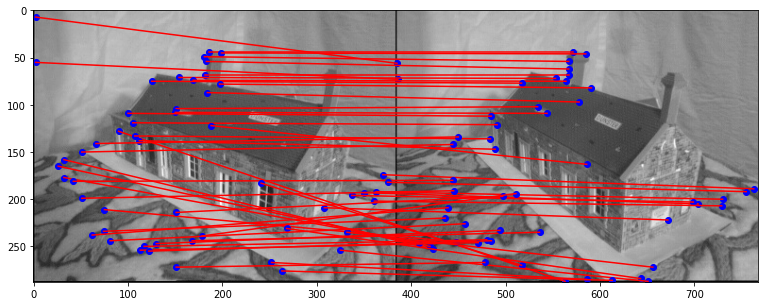

In [665]:
def display_matches(im1, im2, pts1, pts2, matches): ### from a4_utils

	# NOTE: this will only work correctly for images with the same height
	# NOTE: matches should contain index pairs (i.e. first element is the index to pts1 and second for pts2)

	I = np.hstack((im1,im2))
	w = im1.shape[1]
	plt.imshow(I, cmap="gray")
	
	for i, j in matches:
		p1 = pts1[int(i)]
		p2 = pts2[int(j)]
		plt.plot(p1[0], p1[1], 'bo')
		plt.plot(p2[0]+w, p2[1], 'bo')
		plt.plot([p1[0], p2[0]+w], [p1[1], p2[1]], 'r')
		
display_matches(I1, I2, ps1.T, ps2.T, c)

In [678]:
p1s = ps1.T[c[:,0]]
p2s = ps2.T[c[:,1]]

F, r, ins = ransac_fundamental(p1s, p2s, eps=1, k=1000)
print(len(ins))
print("{:.3}% inliers".format(100*len(ins) /p1s.shape[0]))

14
26.9% inliers


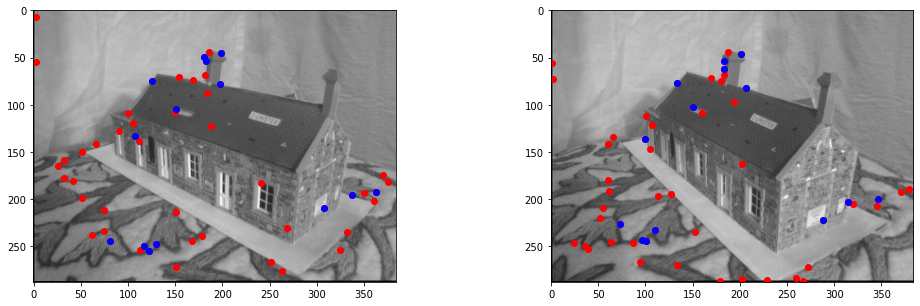

In [679]:
plt.subplot(121)
plt.imshow(I1, cmap="gray")
plt.scatter(p1s[:, 0], p1s[:, 1], color="r")
plt.scatter(p1s[ins, 0], p1s[ins, 1], color="b")

plt.subplot(122)
plt.imshow(I2, cmap="gray")
plt.scatter(p2s[:, 0], p2s[:, 1], color="r")
plt.scatter(p2s[ins, 0], p2s[ins, 1], color="b")

In [680]:
m = 0
for i in range(len(ins)):
	p1 = p1s[ins[i]]
	p2 = p2s[ins[i]]
	re = reproduction_error(np.hstack((p1, 1)), np.hstack((p2, 1)), F)
	m += re
	print("{:.3}".format(re))
m /= len(ins)
print("mean error: {:.3}".format(m))


0.108
0.472
0.205
0.928
0.135
0.707
0.0205
0.000199
0.879
0.000187
0.00113
0.662
0.456
0.0497
mean error: 0.33


---
# Exercise 3: Triangulatio

In [126]:
def triangulate(x1s, x2s, P1, P2):
	Xs = np.zeros((x1s.shape[0], 3))
	for i in range(x1s.shape[0]):
		x1 = x1s[i]
		x1x = np.array([[0, -1, x1[1]], [1, 0, -x1[0]], [-x1[1], x1[0], 0]])
		A1 = x1x @ P1

		x2 = x2s[i]
		x2x = np.array([[0, -1, x2[1]], [1, 0, -x2[0]], [-x2[1], x2[0], 0]])
		A2 = x2x @ P2

		A = np.vstack((A1[:2, :], A2[:2, :]))

		[U, S, V] = np.linalg.svd(A)
		V = V.T
		X = V[:, np.argmin(S)]
		X /= X[-1]

		Xs[i] = X[:3]
	return Xs

In [127]:
P1 = read_data("./data/epipolar/house1_camera.txt").reshape((3,4))
P2 = read_data("./data/epipolar/house2_camera.txt").reshape((3,4))
x1s, x2s = read_points("./data/epipolar/house_points.txt")

In [128]:
Xs = triangulate(x1s, x2s, P1, P2)

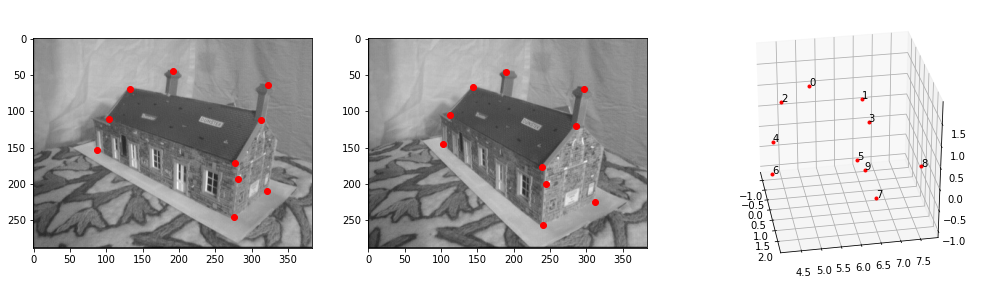

In [129]:
I1 = cv2.imread("./data/epipolar/house1.jpg")
I1 = cv2.cvtColor(I1, cv2.COLOR_BGR2GRAY)
I2 = cv2.imread("./data/epipolar/house2.jpg")
I2 = cv2.cvtColor(I2, cv2.COLOR_BGR2GRAY)


plt.rcParams["figure.figsize"] = (17,5)

fig =  plt.figure()

plt.subplot(131)
plt.imshow(I1, cmap="gray")
plt.scatter(x1s[:,0], x1s[:,1], color='r')

plt.subplot(132)
plt.imshow(I2, cmap="gray")
plt.scatter(x2s[:,0], x2s[:,1], color='r')

ax = fig.add_subplot(133, projection='3d')

T = np.array([[-1,0,0],[0,0,1],[0,-1,0]]) 
res = Xs @ T
ax.view_init(30, -10)
for i, pt in enumerate(res):
	plt.plot([pt[0]],[pt[1]],[pt[2]],'r.')
	ax.text(pt[0],pt[1],pt[2], str(i))
